In [57]:
import numpy as np
from scipy.linalg import logm
import itertools
from time import time
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap

from quantify_core.data.handling import (
    default_datadir,
    get_latest_tuid,
    get_tuids_containing,
    load_dataset,
    locate_experiment_container,
    set_datadir,
)


In [58]:
set_datadir(default_datadir())

Data will be saved in:
/home/pschaefers/quantify-data


In [59]:
tuid = get_latest_tuid(contains="Test transition")
dataset = load_dataset(tuid)
dataset

<xarray.Dataset> Size: 90MB
Dimensions:  (dim_0: 320000)
Coordinates:
    x0       (dim_0) int32 1MB 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999
    x1       (dim_0) int32 1MB 0 0 0 0 0 0 0 0 0 ... 31 31 31 31 31 31 31 31 31
Dimensions without coordinates: dim_0
Data variables: (12/34)
    y0       (dim_0) float64 3MB 0.0 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0 1.0
    y1       (dim_0) float64 3MB 0.0 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0 1.0
    y2       (dim_0) float64 3MB 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    y3       (dim_0) float64 3MB 0.0 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0 1.0
    y4       (dim_0) float64 3MB 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    y5       (dim_0) float64 3MB 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ...       ...
    y28      (dim_0) float64 3MB nan nan nan nan nan nan ... nan nan nan nan nan
    y29      (dim_0) float64 3MB nan nan nan nan nan nan ... nan nan nan nan nan
    y30      (dim_0) float64 3MB nan nan nan nan nan nan ... nan nan nan nan nan
    y31      (dim_0) float64 3MB nan nan nan nan nan nan ... nan nan nan nan nan
    y32      (dim_0) float64 3MB nan nan nan nan nan nan ... nan nan nan nan nan
    y33      (dim_0) float64 3MB nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    tuid:                             20250325-150810-307-9a8288
    name:                             Test transition matrix ['D1', 'D2', 'D3...
    grid_2d:                          True
    grid_2d_uniformly_spaced:         True
    1d_2_settables_uniformly_spaced:  False
    xlen:                             10000
    ylen:                             32
    elements:                         ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D...
    edges:                            []
    states:                           ['00000000000000000', '1010101010101010...
    number_of_repetitions:            10000

In [60]:
def measured_to_counts(dataset):
    elements = dataset.attrs["elements"]
    num_elements = len(elements)
    
    prepStates = dataset.attrs["states"]
    N_states = len(prepStates)

    num_reps = dataset.attrs["number_of_repetitions"]
    
    stacked = np.column_stack([dataset[f"y{i}"] for i in range(num_elements)]).astype(int)
    stacked_strings = np.array(["".join(row.astype(str)) for row in stacked])
   
    # Reshape into groups of `reps`
    reshaped_strings = stacked_strings.reshape(N_states, num_reps)
    
    # Count occurences
    result = {prepStates[i]: dict(zip(*np.unique(reshaped_strings[i], return_counts=True))) for i in range(N_states)}
    
    return result

counts = measured_to_counts(dataset)
# print(counts)

{'00000000000000000': {'00000000000000000': 8803, '00000000000000001': 37, '00000000000000010': 20, '00000000000000100': 65, '00000000000001000': 26, '00000000000001010': 1, '00000000000010000': 33, '00000000000010010': 1, '00000000000100000': 8, '00000000001000000': 3, '00000000010000000': 17, '00000000010000001': 1, '00000000010000010': 1, '00000000100000000': 93, '00000000100000010': 1, '00000000100000100': 1, '00000001000000000': 89, '00000001000100000': 1, '00000010000000000': 73, '00000010000000001': 1, '00000010000000100': 1, '00000010100000000': 1, '00000011000000000': 1, '00000100000000000': 50, '00000100000000100': 1, '00000100100000000': 1, '00000101000000000': 1, '00001000000000000': 59, '00001000000000001': 1, '00001000000100000': 1, '00001100000000000': 1, '00010000000000000': 12, '00100000000000000': 137, '00100000000000010': 1, '00100000000000100': 1, '00100000000010000': 1, '00100000100000000': 3, '00100001000000000': 1, '00100100000000000': 2, '00101000000000000': 2, 

In [61]:
def compute_transition_matrix(data, j, k):  
    """
    Computes the transition matrix A(j, k) for two-qubit errors based on measurement outcomes.

    Parameters:
    - data: Dictionary where keys are input bitstrings and values are dictionaries.
      Each inner dictionary has measured output bitstrings as keys and their counts as values.
    - j, k: The two qubits of interest.

    Returns:
    - A: The 4x4 transition matrix A(j, k), normalized column-wise.
    """
    num_states = 4  # 2-qubit system has 4 possible states: "00", "01", "10", "11"
    A = np.zeros((num_states, num_states))  # Transition matrix
    state_to_index = {"00": 0, "01": 1, "10": 2, "11": 3}
    input_state_counts = np.zeros(num_states)  # Column-wise normalization counts
    
    for x, outcomes in data.items():
        input_state = x[j] + x[k]  # Extract 2-qubit input state
        input_index = state_to_index[input_state]  

        # Mask to remove j and k, preserving other qubits
        mask = [i != j and i != k for i in range(len(x))]
        remaining_input_state = "".join([char for char, include in zip(x, mask) if include])

        for y, count in outcomes.items():
            measured_state = y[j] + y[k]  # Extract 2-qubit measured state
            remaining_output_state = "".join([char for char, include in zip(y, mask) if include])
            
            if remaining_input_state == remaining_output_state:
                output_index = state_to_index[measured_state]
                A[output_index, input_index] += count
                input_state_counts[input_index] += count  # Track input occurrences
    
    # Normalize each column
    for col in range(num_states):
        if input_state_counts[col] > 0:
            A[:, col] /= input_state_counts[col]

    return A

# compute_transition_matrix(counts,0,1)

In [62]:
def plot_2qb_transition_matrix(matrix, qubits):
    # Define the labels
    labels = ["00", "01", "10", "11"]
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(6, 5))
    
    # Mask for diagonal elements (True for diagonal, False for off-diagonal)
    diag_mask = np.zeros_like(matrix, dtype=bool)
    np.fill_diagonal(diag_mask, True)  # Diagonal elements are True

    # Create a custom colormap for diagonal elements (shades of dark blue)
    blues_dark = LinearSegmentedColormap.from_list("blues_dark", ["#1f3a64", "#4b79a1"])
    
    # Plot the off-diagonal elements with a red colormap
    cax_off_diag = ax.matshow(np.ma.masked_array(matrix, mask=diag_mask), cmap="Reds", 
                              vmin=0.0, vmax=0.05, alpha=0.6)
    
    # Plot the diagonal elements with the custom dark blue colormap
    cax_diag = ax.matshow(np.ma.masked_array(matrix, mask=~diag_mask), cmap=blues_dark, 
                          vmin=0.9, vmax=1.0, alpha=1)
    
    # Add colorbars for both
    fig.colorbar(cax_diag, ax=ax, shrink=0.8, label="Diagonal elements")
    fig.colorbar(cax_off_diag, ax=ax, shrink=0.8, label="Off-diagonal elements")
    
    # Set tick labels
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    
    # Annotate the values inside the cells
    for i in range(len(labels)):
        for j in range(len(labels)):
            # Set text color to white if it's on the diagonal, else black
            text_color = "white" if i == j else "black"
            ax.text(j, i, f"{matrix[i, j]:.4f}", ha="center", va="center", color=text_color)

    # Set title
    plt.title(f"Transition matrix qubits {' '.join(qubit for qubit in qubits)}")

    # Move the x-ticks to the lower x-axis (if not already there)
    ax.xaxis.set_ticks_position('bottom')

    # Set x and y axis labels
    ax.set_xlabel("Prepared state")
    ax.set_ylabel("Assigned state")

    
    
    # Display the plot
    plt.show()

    return None

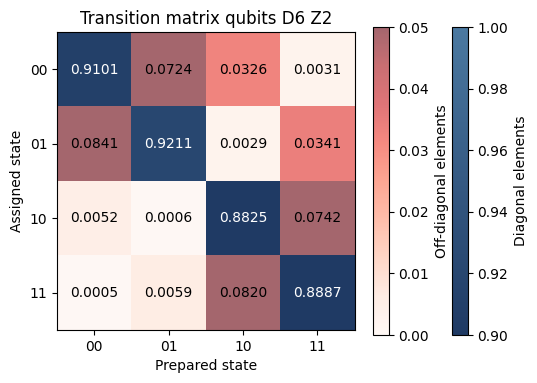

In [63]:
qubits = dataset.attrs["elements"]
N_qubits = len(qubits)

arr = np.arange(N_qubits)  # [0, 1, 2]
combinations = list(itertools.combinations(arr, 2))

objective = 0

for i in combinations:
    tmp = compute_transition_matrix(counts,i[0],i[1])
    if qubits[i[0]] == "D6" and qubits[i[1]] == "Z2":
        plot_2qb_transition_matrix(tmp, [qubits[i[0]],qubits[i[1]]])
    

In [64]:
def objective(dataset):
    counts = measured_to_counts(dataset)
    
    qubits = dataset.attrs["elements"]
    N_qubits = len(qubits)
    
    arr = np.arange(N_qubits)
    combinations = list(itertools.combinations(arr, 2))
    
    objective = 0
    
    for i in combinations:
        if (qubits[i[0]] == "D6" and qubits[i[1]] == "Z2") or (qubits[i[0]] == "D6" and qubits[i[1]] == "D8") or (qubits[i[0]] == "D8" and qubits[i[1]] == "Z2"):
            tmp = compute_transition_matrix(counts,i[0],i[1])
            print(np.sum(tmp) - np.trace(tmp),"     ", qubits[i[0]], qubits[i[1]])
            objective += np.sum(tmp) - np.trace(tmp)

    return objective

In [65]:
start = time()
objective_old = objective(dataset)

end = time()

print(end-start)

0.3685396878421976       D6 D8
0.39759202685778927       D6 Z2
0.5869167072949888       D8 Z2
4.8932952880859375


In [66]:
print(end-start)

4.8932952880859375


In [67]:
tuid = get_latest_tuid(contains="transition")
dataset = load_dataset(tuid)
dataset

<xarray.Dataset> Size: 68kB
Dimensions:  (dim_0: 850)
Coordinates:
    x0       (dim_0) float64 7kB 7.064e+09 7.064e+09 ... 7.075e+09 7.075e+09
    x1       (dim_0) float64 7kB 0.005 0.07461 0.01975 ... 0.05353 0.05353
    x2       (dim_0) float64 7kB 5.6e-08 1.08e-07 7.6e-08 ... 2.92e-07 2.84e-07
    x3       (dim_0) float64 7kB 7.796e+09 7.803e+09 ... 7.833e+09 7.832e+09
    x4       (dim_0) float64 7kB 0.05737 0.005 0.0256 ... 0.09895 0.09852
    x5       (dim_0) float64 7kB 4e-08 1.16e-07 4.8e-08 ... 2.76e-07 2.72e-07
    x6       (dim_0) float64 7kB 7.579e+09 7.611e+09 ... 7.607e+09 7.608e+09
    x7       (dim_0) float64 7kB 0.005 0.0229 0.009993 ... 0.05918 0.05679
    x8       (dim_0) float64 7kB 4e-08 1.08e-07 8.4e-08 ... 2.32e-07 2.32e-07
Dimensions without coordinates: dim_0
Data variables:
    y0       (dim_0) float64 7kB 9.06 7.536 8.389 8.935 ... 0.9708 1.116 0.9908
Attributes:
    tuid:                             20250327-131111-876-036ab2
    name:                             CMAES_transition_matrix_['D8', 'D6', 'Z2']
    grid_2d:                          False
    grid_2d_uniformly_spaced:         False
    1d_2_settables_uniformly_spaced:  True
    elements:                         ['D8', 'D6', 'Z2']
    edges:                            []

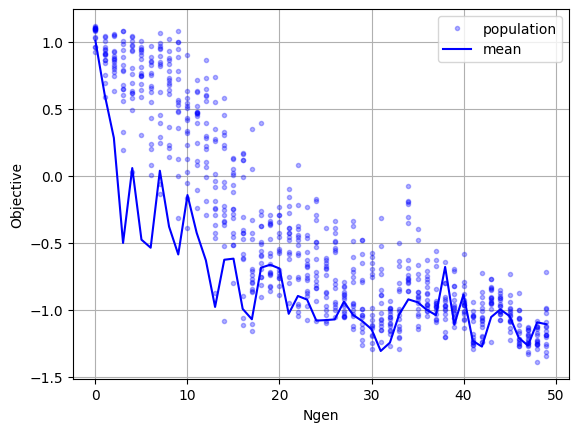

In [91]:
popsize = 16
Ngen = 50

objective = np.log(dataset.y0.data/3)

mean_indices = np.arange(popsize, len(objective), popsize + 1)
# print(mean_indices)
objective_mean = objective[mean_indices]
objective_population = np.delete(objective, mean_indices)
# print(objective_population.shape)
# print(objective_population[0::popsize])

# print(objective_mean[-1])

for i in range(popsize):
    if i == 0:
        plt.plot(range(Ngen),objective_population[i::popsize],".",c="blue",alpha=.3, label = "population")
    else:
        plt.plot(range(Ngen),objective_population[i::popsize],".",c="blue",alpha=.3)

plt.plot(range(Ngen),objective_mean,c="blue", label="mean")
plt.grid()
plt.legend()
plt.xlabel("Ngen")
plt.ylabel("Objective")
# plt.hlines(objective_old/3,0,Ngen,linestyles="--", color="red")
plt.show()

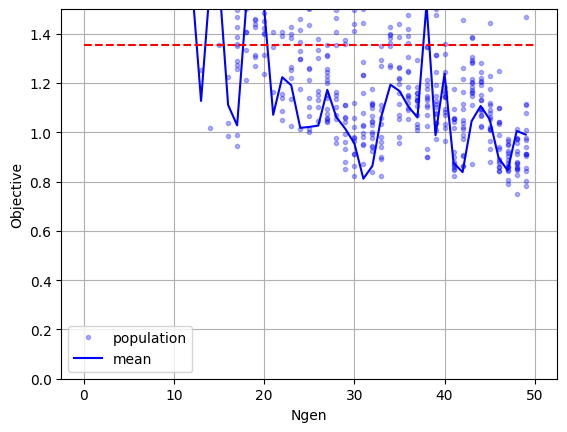

In [79]:
for i in range(popsize):
    if i == 0:
        plt.plot(range(Ngen),objective_population[i::popsize],".",c="blue",alpha=.3, label = "population")
    else:
        plt.plot(range(Ngen),objective_population[i::popsize],".",c="blue",alpha=.3)

plt.plot(range(Ngen),objective_mean,c="blue", label="mean")
plt.grid()
plt.legend(loc = "lower left")
plt.xlabel("Ngen")
plt.ylabel("Objective")
plt.hlines(objective_old,0,Ngen, linestyles="--", color="red")
plt.ylim(0,1.5)
plt.show()